In [2]:
import os
import sys
import glob

sys.path.append("/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D/arm_and_hand")
sys.path.append("/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D")

from dataloader_ann import HandArmLandmarksDataset_ANN

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from datetime import datetime

import open3d as o3d
from utilities import convert_to_shoulder_coord
import time

from sklearn.preprocessing import MinMaxScaler

import pandas as pd
from csv_writer import fusion_csv_columns_name
import matplotlib.pyplot as plt

import joblib
import sklearn

import json

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
DATA_DIR = "/home/giakhang/dev/pose_sandbox/data"  
SELECTED_DATE = "2024-0*"  # Keep '*' when using glob.glob

train_paths = glob.glob(os.path.join(DATA_DIR, "{}/{}/fine_landmarks_{}_*.csv".format(SELECTED_DATE, SELECTED_DATE, "train")))
val_paths = glob.glob(os.path.join(DATA_DIR, "{}/{}/fine_landmarks_{}_*.csv".format(SELECTED_DATE, SELECTED_DATE, "val")))

#fake_train_paths = glob.glob(os.path.join(DATA_DIR, "fake_data", "train", "fake_*.csv"))

#if len(fake_train_paths) > 0:
    #train_paths.extend(fake_train_paths)

body_lines = [[0,2], [0, 3], [2, 4], [3, 4]]
lefthand_lines = [[0, 1], [1, 5], [5, 6], [5, 10], [5, 22], [10, 14], [14, 18], [18, 22], 
    [6, 7], [7, 8], [8, 9], 
    [10, 11], [11, 12], [12, 13], 
    [14, 15], [15, 16], [16, 17], 
    [18, 19], [19, 20], [20, 21], 
    [22, 23], [23, 24], [24, 25]]
train_body_distance_thres = 550
train_leftarm_distance_thres = 550
train_lefthand_distance_thres = 200
val_body_distance_thres = 450
val_leftarm_distance_thres = 450
val_lefthand_distance_thres = 150

train_dataset = HandArmLandmarksDataset_ANN(train_paths, 
    body_lines, 
    lefthand_lines, 
    train_body_distance_thres, 
    train_leftarm_distance_thres, 
    train_lefthand_distance_thres,
    filter_outlier=True,
    only_keep_frames_contain_lefthand=True)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataset = HandArmLandmarksDataset_ANN(val_paths,
    body_lines,
    lefthand_lines,
    val_body_distance_thres,
    val_leftarm_distance_thres,
    val_lefthand_distance_thres,
    filter_outlier=True,
    only_keep_frames_contain_lefthand=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)  

In [4]:
train_dataset._outputs.shape

(10876, 144)

In [5]:
val_dataset._outputs.shape

(979, 144)

In [6]:
arm_hand_fused_names = ["left shoulder", "left elbow", "left hip", "right shoulder", "right hip", 
 "WRIST", "THUMB_CMC", "THUMB_MCP", "THUMB_IP", "THUMB_TIP", "INDEX_FINGER_MCP", 
 "INDEX_FINGER_PIP", "INDEX_FINGER_DIP", "INDEX_FINGER_TIP", "MIDDLE_FINGER_MCP", 
 "MIDDLE_FINGER_PIP", "MIDDLE_FINGER_DIP", "MIDDLE_FINGER_TIP", "RING_FINGER_MCP", 
 "RING_FINGER_PIP", "RING_FINGER_DIP", "RING_FINGER_TIP", "PINKY_MCP", "PINKY_PIP", 
 "PINKY_DIP", "PINKY_TIP", "right elbow"]

EDA ground truth (after converting to shoulder coordinate) to apply with Kalman Filter

In [7]:
target_output = train_dataset._outputs  #  shape: (N, 144)
target_output = target_output.reshape(-1, 3, 48)
target_output = np.transpose(target_output, (0, 2, 1))
target_output.shape

#target_outputs_cvt_to_shoulder_coords = []
#for i in range(target_output.shape[0]):
    #output = target_output[i]
    #output = output.reshape(3, 48)  # shape: (3, 48)
    #output = output.T  # shape: (48, 3)
    #points, _ = convert_to_shoulder_coord(output, arm_hand_fused_names)
    #target_outputs_cvt_to_shoulder_coords.append(points)

#target_outputs_cvt_to_shoulder_coords = np.array(target_outputs_cvt_to_shoulder_coords)
#target_outputs_cvt_to_shoulder_coords.shape

(10876, 48, 3)

In [7]:
def get_expectation_cov_mats(landmark_xyz):
    dict_result = dict()
    landmarks_df = pd.DataFrame(landmark_xyz)
    
    Q1 = landmarks_df.quantile(0.25)
    Q3 = landmarks_df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
        
    outlier_condition = (landmarks_df < lower_bound) | (landmarks_df > upper_bound)

    filtered_df = landmarks_df[~np.any(outlier_condition.to_numpy(), axis=1)]

    outliers = landmarks_df[outlier_condition]
    abs_noise = np.abs(outliers - np.where(outliers < lower_bound, lower_bound, upper_bound))

    measure_noise = abs_noise.cov()
    cov = filtered_df.cov()
    expectation = filtered_df.mean()

    measure_noise = measure_noise.fillna(0)

    print("-----------")
    print("Det measure: ", np.linalg.det(measure_noise))
    print("cov: ", np.linalg.det(cov))

    dict_result["measure_noise"] = measure_noise.to_numpy().flatten().tolist()
    dict_result["filter_state_estimate"] = expectation.to_numpy().tolist()
    dict_result["cov"] = cov.to_numpy().flatten().tolist()

    return dict_result

In [8]:
landmark_stats_dict = dict()

for i, landmark_name in enumerate(arm_hand_fused_names):
    landmark_xyz = target_output[:, i, :]
    landmark_stats = get_expectation_cov_mats(landmark_xyz)
    landmark_stats_dict[landmark_name] = landmark_stats

-----------
Det measure:  2359676578.8921432
cov:  451988595287.24396
-----------
Det measure:  2678689343.3763638
cov:  1989319174634.9404
-----------
Det measure:  0.0
cov:  3141155170241.2656
-----------
Det measure:  215342164299.91364
cov:  40545758922.072205
-----------
Det measure:  0.0
cov:  1417505801470.8208
-----------
Det measure:  214510196764.22507
cov:  1207410229740.7493
-----------
Det measure:  328492871020.7817
cov:  925959673111.294
-----------
Det measure:  351566734241.27594
cov:  656055829191.5563
-----------
Det measure:  605543958130.4984
cov:  823611499426.6151
-----------
Det measure:  770081161487.6158
cov:  940662431626.6162
-----------
Det measure:  750374489361.1641
cov:  791984369572.4373
-----------
Det measure:  1092482939533.3413
cov:  561985059539.8047
-----------
Det measure:  1196872088287.0146
cov:  503729878022.86926
-----------
Det measure:  1286544845859.1199
cov:  509967418177.76587
-----------
Det measure:  628338703045.5046
cov:  78738994643

In [9]:
with open("landmark_stats.json", 'w') as file:
    json.dump(landmark_stats_dict, file)

In [8]:
output_columns_name = np.array(fusion_csv_columns_name[-144:])
output_columns_name = np.reshape(output_columns_name, (3, 48))

Visualize box plots from *left_shoulder -> right_elbow* (27 joints in total)

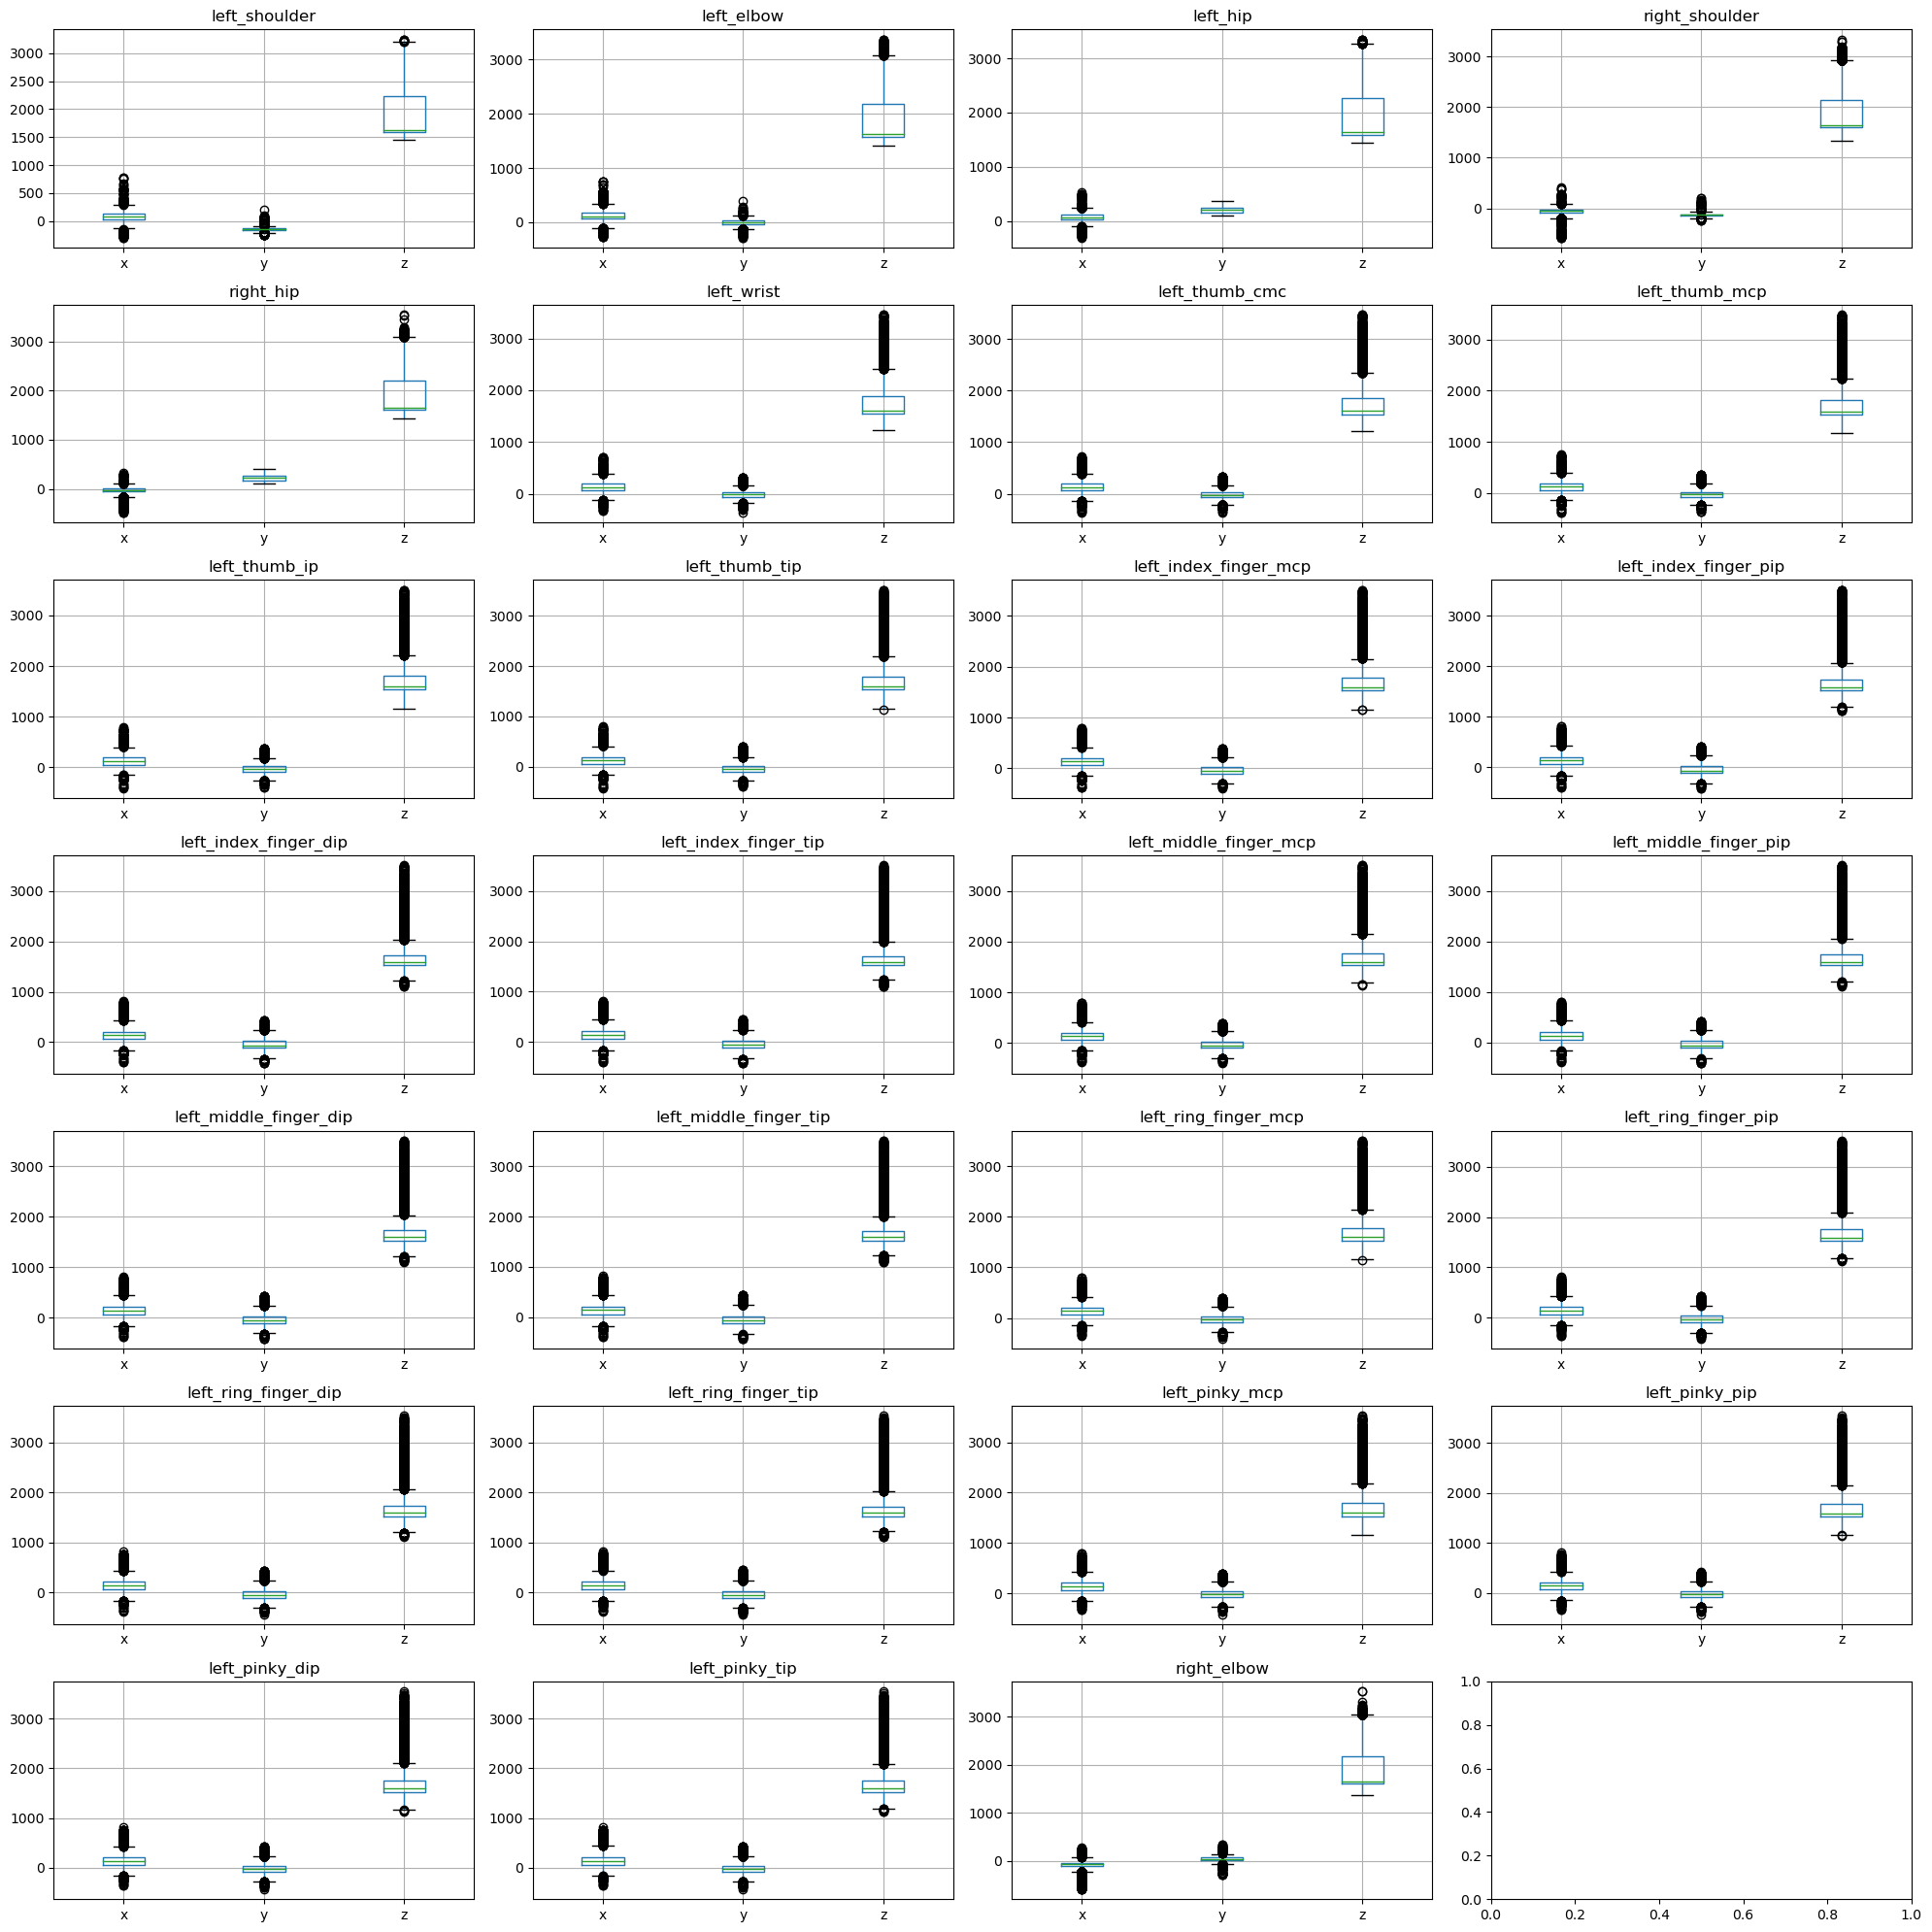

In [9]:
fig, axes = plt.subplots(7, 4, figsize=(20, 20))
axes = axes.flatten()

for i in range(len(arm_hand_fused_names)):
    ax = axes[i]
    df = pd.DataFrame(target_output[:, i, :], columns=output_columns_name[:, i])
    df.boxplot(ax=ax)
    title = output_columns_name[:, i][0].split("_output")[0]
    ax.set_title(title)
    ax.set_xticklabels(["x", "y", "z"])

plt.tight_layout()
plt.show()

# Inspect val set

In [10]:
val_gt = val_dataset._outputs  #  shape: (N, 144)
val_gt = val_gt.reshape(-1, 3, 48)
val_gt = np.transpose(val_gt, (0, 2, 1))
val_gt.shape

(979, 48, 3)

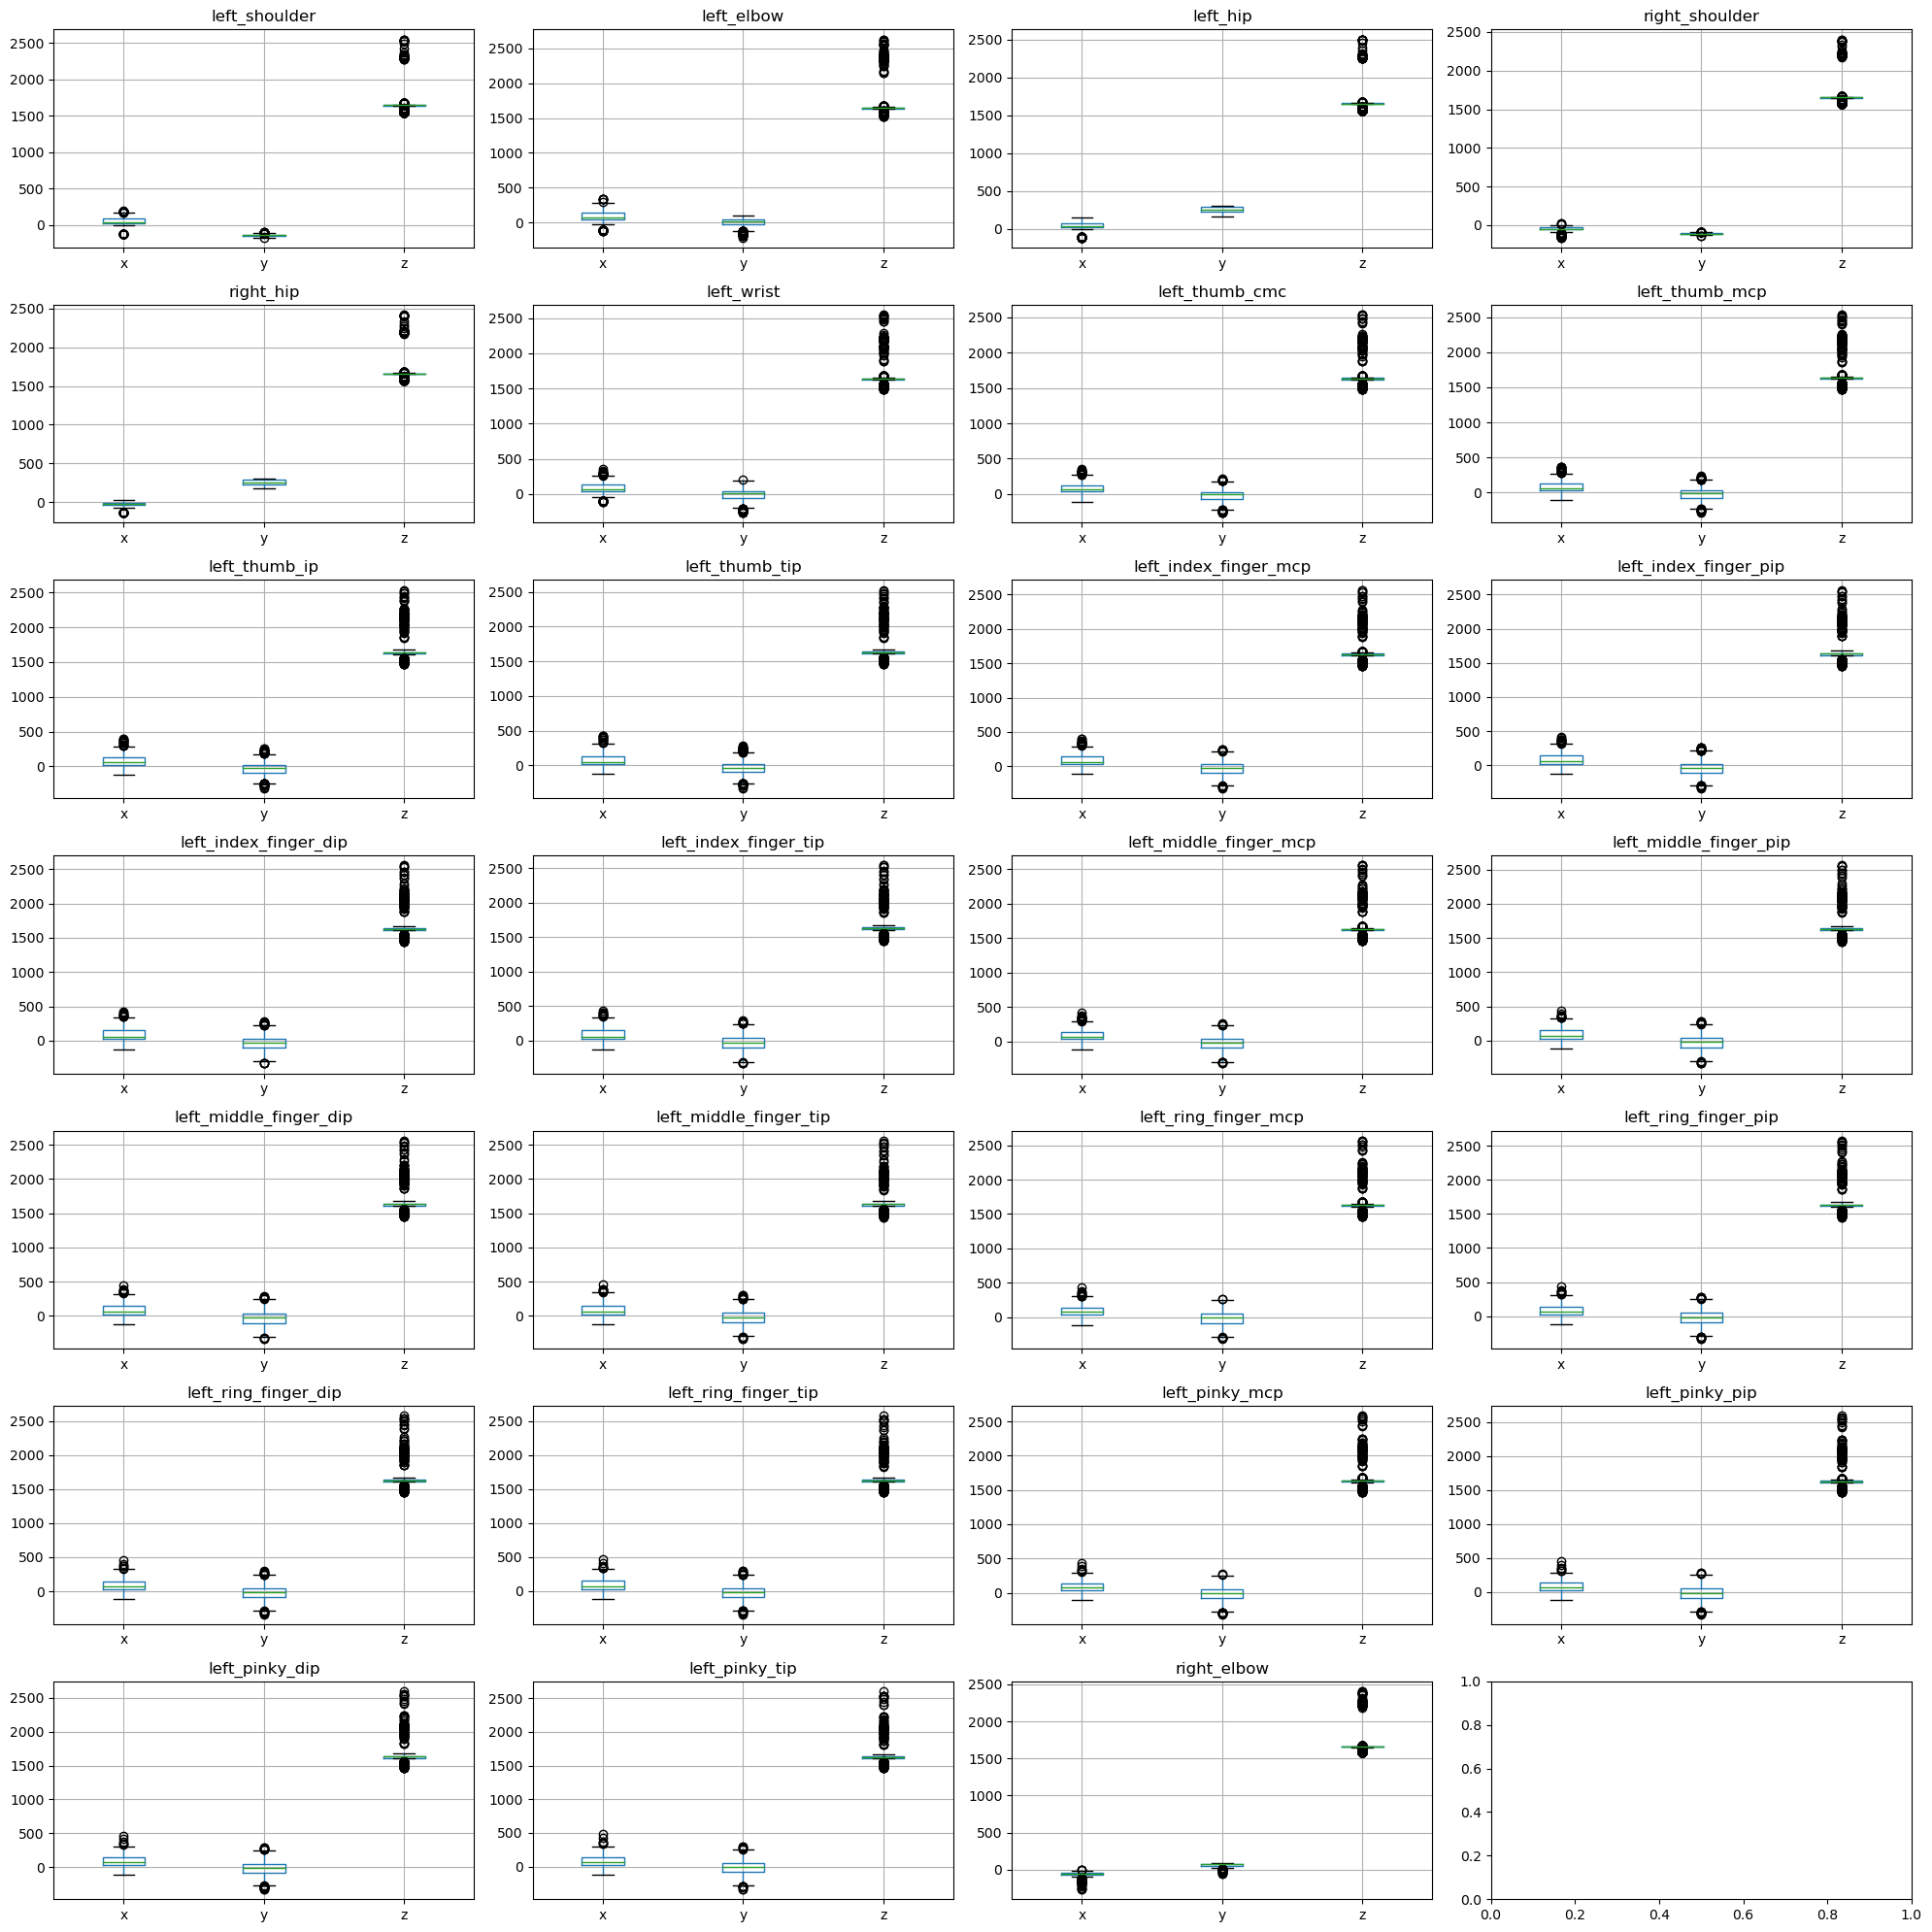

In [11]:
fig, axes = plt.subplots(7, 4, figsize=(20, 20))
axes = axes.flatten()

for i in range(len(arm_hand_fused_names)):
    ax = axes[i]
    df = pd.DataFrame(val_gt[:, i, :], columns=output_columns_name[:, i])
    df.boxplot(ax=ax)
    title = output_columns_name[:, i][0].split("_output")[0]
    ax.set_title(title)
    ax.set_xticklabels(["x", "y", "z"])

plt.tight_layout()
plt.show()